In [165]:
%matplotlib inline
from utils import *
from tqdm import *
from os.path import join
from matplotlib import pyplot as plt
from skimage.measure import block_reduce
from multiprocessing import Pool
import numpy as np
import librosa
from tqdm import tqdm

In [166]:
data_root = 'drumData'
n_fft = 1024
hop_length = n_fft/4
use_logamp = False # boost the brightness of quiet sounds
reduce_rows = 10 # how many frequency bands to average into one
reduce_cols = 1 # how many time steps to average into one
crop_rows = 32 # limit how many frequency bands to use
crop_cols = 32 # limit how many time steps to use
limit = None # set this to 100 to only process 100 samples

In [167]:
drumNames = ["kick", "tom", "snare", "clap", "hi.hat", "ride", "crash"]
drumFingerPrints = {}
drumSamples = {}
for d in drumNames:
    %time drumSamples[d] = np.load(join(data_root, d+'_samples.npy'))

CPU times: user 1.02 ms, sys: 141 ms, total: 142 ms
Wall time: 141 ms
CPU times: user 749 µs, sys: 6.81 ms, total: 7.56 ms
Wall time: 7.24 ms
CPU times: user 925 µs, sys: 40.9 ms, total: 41.8 ms
Wall time: 41.7 ms
CPU times: user 773 µs, sys: 20.5 ms, total: 21.3 ms
Wall time: 21.1 ms
CPU times: user 869 µs, sys: 3.5 ms, total: 4.36 ms
Wall time: 4.21 ms
CPU times: user 811 µs, sys: 4.59 ms, total: 5.4 ms
Wall time: 5.11 ms
CPU times: user 737 µs, sys: 11.6 ms, total: 12.3 ms
Wall time: 12 ms


# Aggregating features across timesteps to form x_data

In [168]:
'''
drums_and_features is a dictionary containing the drum type and 
the np.array of features. 
'''
drums_and_features = {} 
for drumName in drumNames: 
    file_path = './drumData/' + drumName + '_MIRfeatures.npy'
    drums_and_features[drumName] = np.load(file_path)

In [169]:
crash = drums_and_features['crash']
print(crash.shape)
print(crash[0].shape)

(723, 6, 24)
(6, 24)


In [170]:
feat_means = np.mean(crash,axis=2)
feat_stds = np.mean(crash,axis=2)
print(feat_means.shape, feat_stds.shape)
agg_feat = np.concatenate((feat_means,feat_stds),axis=1)
print(agg_feat.shape)

((723, 6), (723, 6))
(723, 12)


In [171]:
x_data = []
for drumName in drumNames: 
    file_path = './drumData/' + drumName + '_MIRfeatures.npy'
    drum_features = np.load(file_path)
    feat_means = np.mean(drum_features,axis=2)
    feat_stds = np.std(drum_features,axis=2)
    print(feat_means.shape, feat_stds.shape)
    agg_feat = np.concatenate((feat_means,feat_stds),axis=1)
    print(agg_feat.shape)
    x_data.extend(agg_feat)
x_data = np.asarray(x_data)
print("x_data.shape:", x_data.shape)

((5158, 6), (5158, 6))
(5158, 12)
((422, 6), (422, 6))
(422, 12)
((2546, 6), (2546, 6))
(2546, 12)
((1324, 6), (1324, 6))
(1324, 12)
((159, 6), (159, 6))
(159, 12)
((228, 6), (228, 6))
(228, 12)
((723, 6), (723, 6))
(723, 12)
('x_data.shape:', (10560, 12))


# Forming y_data

In [172]:
'''
drums_and_features is a dictionary containing the drum type and 
the np.array of features. 
'''
drums_and_features = {} 
for drumName in drumNames: 
    file_path = './drumData/' + drumName + '_MIRfeatures.npy'
    drums_and_features[drumName] = np.load(file_path)

In [173]:
crash = drums_and_features['crash']
print(crash.shape)
print(crash[0].shape)

(723, 6, 24)
(6, 24)


In [174]:
drum_labels = []
for i, drumName in enumerate(drumNames): 
    print(drums_and_features[drumName].shape)
    (num_samples,_,_) = drums_and_features[drumName].shape
    drum_labels.extend([i] * num_samples)

(5158, 6, 24)
(422, 6, 24)
(2546, 6, 24)
(1324, 6, 24)
(159, 6, 24)
(228, 6, 24)
(723, 6, 24)


(10560,)


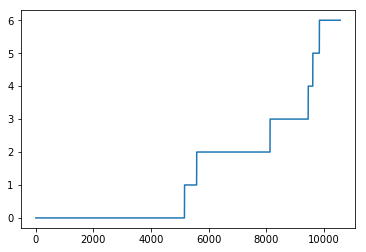

In [175]:
y_data = np.asarray(drum_labels)
print(y_data.shape)
plt.plot(y_data)

#### Splitting into randomized training set and test set

In [176]:
# Randomize the dataset
random_idx = [i for i in range(len(x_data))]
from random import shuffle
shuffle(random_idx)
data_X = x_data[random_idx]
data_Y = y_data[random_idx]

10560
[ True  True  True ...,  True  True False]
(9504, 12)
(9504,)
(1056, 12)
(1056,)


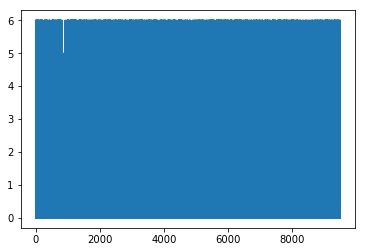

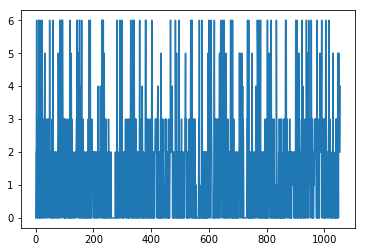

In [177]:
# Split data in testing and training set
train_test_split = np.random.rand(len(data_X)) < 0.90
print(len(train_test_split))
train_X = data_X[train_test_split]
train_Y = data_Y[train_test_split]
test_X = data_X[~train_test_split]
test_Y = data_Y[~train_test_split]
print(train_test_split)
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)
plt.figure()
plt.plot(train_Y)
plt.figure()
plt.plot(test_Y)

# Running K-means Clustering

#### Using a feature vector of 12 with aggregated features

In [207]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7).fit(x_data)

In [208]:
pred_Y = kmeans.predict(x_data)
from sklearn.metrics import confusion_matrix
confusion_matrix(pred_Y,y_data)

array([[5158,  422, 2546, 1324,  159,  228,  723],
       [   0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0]])

In [195]:
print(kmeans.cluster_centers_)

[[ -3.35761729e-18   9.70340488e-16  -4.83254138e-18  -8.70362046e-18
    2.00475119e-19   8.46086827e-18   1.00000000e+00   1.00000000e+00
    1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00]
 [  1.21155290e-17  -3.37164159e-15   1.26882631e-17  -1.33270819e-18
   -1.63008936e-18  -2.33499287e-17   1.00000000e+00   1.00000000e+00
    1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00]
 [ -9.80785965e-18  -9.06634529e-16   4.67040936e-19   1.01887204e-18
    1.36637274e-18   1.05570712e-17   1.00000000e+00   1.00000000e+00
    1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00]
 [ -1.41861831e-16   1.25439782e-14   5.47401630e-17  -1.95831006e-16
   -1.23358114e-17   1.38777878e-16   1.00000000e+00   1.00000000e+00
    1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00]
 [  2.26156542e-17  -1.16912652e-14   9.97144754e-17  -1.02798428e-17
   -1.54197642e-18   1.22844122e-16   1.00000000e+00   1.00000000e+00
    1.00000000e+

#### Using raw 6x24 matrix

In [209]:
x_data_timesteps = []
for drumName in drumNames: 
    file_path = './drumData/' + drumName + '_MIRfeatures.npy'
    drum_features = np.load(file_path)
    x_data_timesteps.extend(drum_features)
x_data_timesteps = np.asarray(x_data_timesteps)
print("x_data_timesteps.shape:", x_data_timesteps.shape)
x_data_timesteps = x_data_timesteps.reshape(len(x_data_timesteps),-1)
print("x_data_timesteps.shape:", x_data_timesteps.shape)
y_data_timesteps = y_data
print("y_data_timesteps.shape:", y_data_timesteps.shape)

('x_data_timesteps.shape:', (10560, 6, 24))
('x_data_timesteps.shape:', (10560, 144))
('y_data_timesteps.shape:', (10560,))


In [210]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7).fit(x_data_timesteps)

In [211]:
pred_Y = kmeans.predict(x_data_timesteps)
from sklearn.metrics import confusion_matrix
confusion_matrix(pred_Y,y_data_timesteps)

array([[3246,  230,   14,   21,    0,    0,   10],
       [ 397,  105,  448,  708,   92,  151,   41],
       [  14,    1,    8,    2,    0,    6,  311],
       [ 268,   24,  541,  284,   40,   23,   10],
       [ 119,    8,  475,   78,   11,   24,  318],
       [1063,   52,   87,   57,    9,    4,   10],
       [  51,    2,  973,  174,    7,   20,   23]])

# Using a sklearn example

In [232]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

#digits = load_digits()
#data = scale(digits.data)
data = x_data_timesteps

n_samples, n_features = data.shape
#n_digits = len(np.unique(digits.target))
n_digits = 7
labels = y_data_timesteps

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')


n_digits: 7, 	 n_samples 10560, 	 n_features 144
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	2.43s	563026	0.379	0.302	0.336	0.344	0.301	0.140
random   	2.01s	563013	0.378	0.302	0.336	0.344	0.301	0.150
PCA-based	0.27s	577394	0.369	0.277	0.316	0.279	0.276	0.103
__________________________________________________________________________________


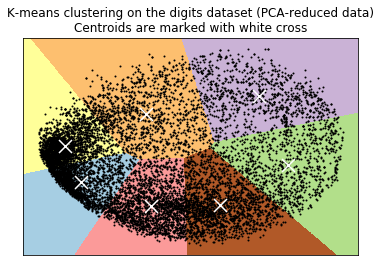

In [217]:
# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

# Sklearn example on stft fingerprints

In [219]:
import pickle
data_root = 'drumData/'
initial_dims = [30]
perplexities = [30]
mode = 'fingerprints'
drumNames = pickle.load(open(data_root+'drumNames.pickle'))
drumLengths = pickle.load(open(data_root+'drumLengths.pickle'))

In [226]:
drumPrints = []
drumLabels = []
for i, drum in enumerate(drumNames):
    STFT_feat = np.load(join(data_root, drum+'_fingerprints.npy'))
    drumPrints.extend(STFT_feat)
    drumLabels.extend([i] * STFT_feat.shape[0])
    #print drum, drumPrints[-1].shape
drumPrints = np.asarray(drumPrints)
drumLabels = np.asarray(drumLabels)
print(drumPrints.shape)
print(drumLabels.shape)

(10560, 32, 32)
(10560,)


In [227]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

#digits = load_digits()
#data = scale(digits.data)

drumPrints = drumPrints.reshape(len(drumPrints),-1)
data = drumPrints

n_samples, n_features = data.shape
#n_digits = len(np.unique(digits.target))
n_digits = len(drumNames)
labels = drumLabels

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')


n_digits: 7, 	 n_samples 10560, 	 n_features 1024
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	8.20s	49845	0.507	0.439	0.470	0.422	0.438	0.214
random   	11.87s	49845	0.508	0.439	0.471	0.421	0.439	0.246
PCA-based	1.71s	49846	0.508	0.439	0.471	0.421	0.439	0.195
__________________________________________________________________________________


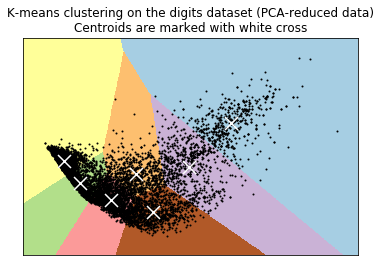

In [228]:
# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

# Silhoute coefficient example


drums_and_features is a dictionary containing the drum type and 
the np.array of features. 

For n_clusters = 2 The average silhouette_score is : 0.408488


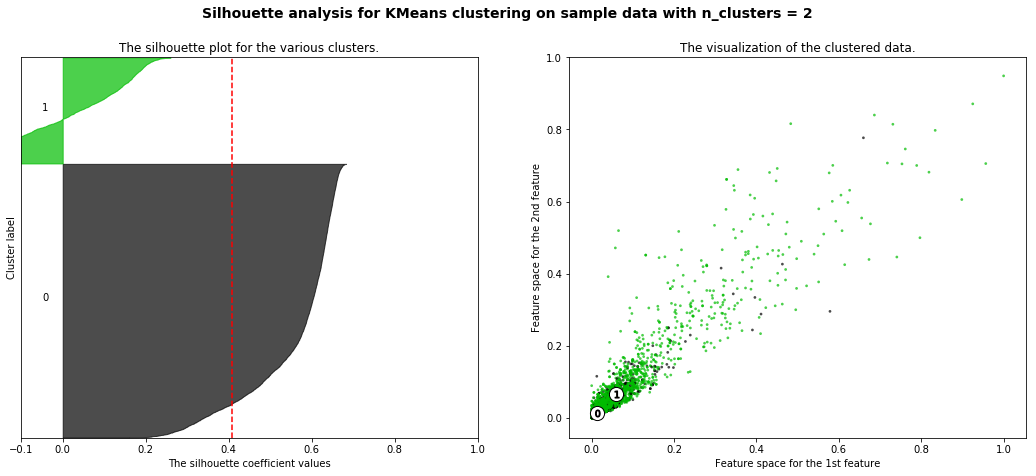

For n_clusters = 3 The average silhouette_score is : 0.30925


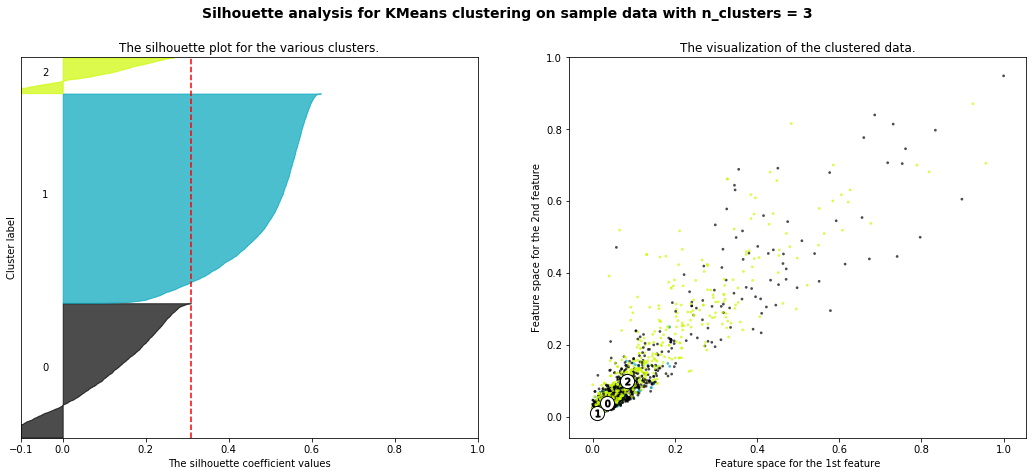

For n_clusters = 4 The average silhouette_score is : 0.25038


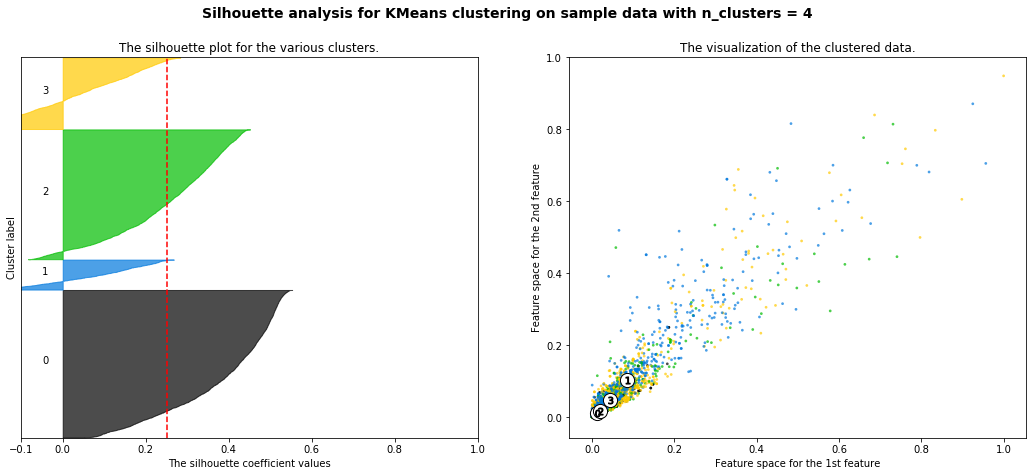

For n_clusters = 5 The average silhouette_score is : 0.210838


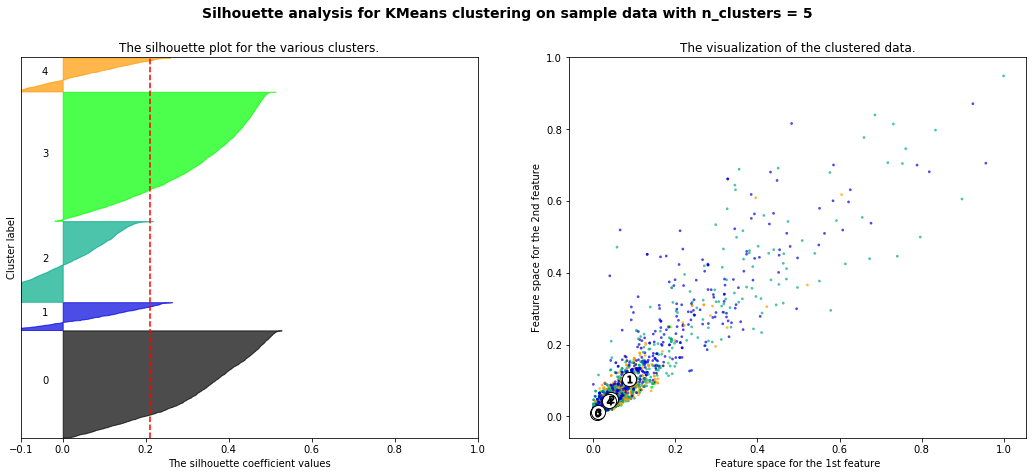

For n_clusters = 6 The average silhouette_score is : 0.20376


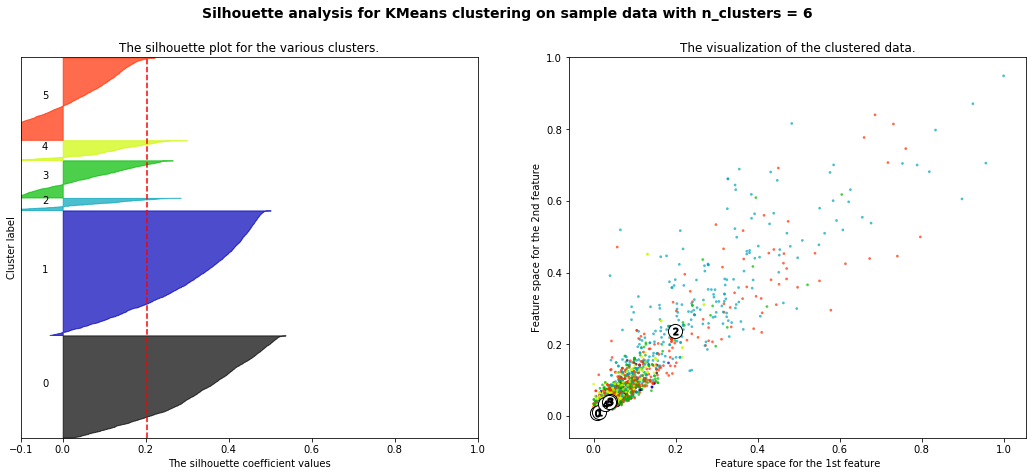

For n_clusters = 7 The average silhouette_score is : 0.22311


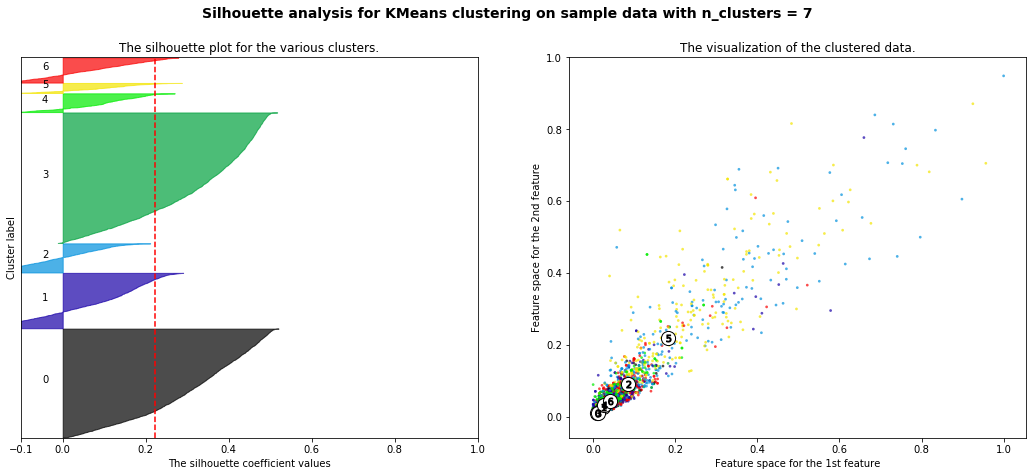

In [230]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X = drumPrints
y = drumLabels

range_n_clusters = [2, 3, 4, 5, 6, 7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()